In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

#Mine useful starting lines
from costs import *
from gradient_descent import *
from stochastic_gradient_descent import *
from grid_search import *
from helpers import *
from plots_lab2 import grid_visualization, gradient_descent_visualization

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    D = tx.shape[1]
    G = tx.T.dot(tx)
    if(np.linalg.matrix_rank(G)==D):
        w = np.linalg.inv(G).dot(tx.T).dot(y)
    else:
        w = np.linalg.solve(G,tx.T.dot(y))
    loss = compute_loss(y, tx, w)
    return w, loss

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    #grid search
    grid_w0, grid_w1 = generate_w(num_intervals=100)
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    loss_grid, w0_grid, w1_grid = get_best_parameters(grid_w0, grid_w1, grid_losses)
    w_grid = [w0_grid, w1_grid]
    print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}".format(
      l=loss_grid, w0=w0_grid, w1=w1_grid))
    
    #gradient descend
    max_iters = 50
    gamma = 0.7
    w_initial = np.array([0, 0])
    gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
    w_gd, loss_gd=gradient_ws.pop(), gradient_losses.pop()
    print("Gradient Descend: loss*={l}, w0*={w0}, w1*={w1}".format(
      l=loss_gd, w0=w_gd[0], w1=w_gd[1]))
    
    #least squares
    w_ls, loss_ls = least_squares(y, tx)
    print("Least squares: loss*={l}, w0*={w0}, w1*={w1}".format(
      l=loss_ls, w0=w_ls[0], w1=w_ls[1]))
    
    grid_loss_err = np.linalg.norm(loss_ls - loss_grid)/np.linalg.norm(loss_ls)
    grid_w_err = np.linalg.norm(w_ls - w_gd)/np.linalg.norm(w_ls)
    
    gd_loss_err = np.linalg.norm(loss_ls - loss_gd)/np.linalg.norm(loss_ls)
    gd_w_err = np.linalg.norm(w_ls - w_gd)/np.linalg.norm(w_ls)
    
    print("Grid search errors: loss={gr_l}, w={gr_w}".format(
      gr_l=grid_loss_err, gr_w=grid_w_err))
    print("Gradient descend errors: loss={gr_l}, w={gr_w}".format(
      gr_l=gd_loss_err, gr_w=gd_w_err))

Test it here

In [4]:
test_your_least_squares()

Grid Search: loss*=15.55870336860953, w0*=72.72727272727272, w1*=13.636363636363626
Gradient Descend: loss*=15.3858878688294, w0*=73.29392200210519, w1*=13.479712434989048
Least squares: loss*=15.3858878688294, w0*=73.2939220021052, w1*=13.479712434989061
Grid search errors: loss=0.011232078463943621, w=2.5338340126066793e-16
Gradient descend errors: loss=0.0, w=2.5338340126066793e-16


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

- High degree: best fit possible in terms of passing through the point, but computational expensive and possible overfitting (we need a lot of data to avoid overfitting)
- Low degree: easy to implement, computational not expensive, less cost for regression but it's possible that it doen't represent our data at all

In [26]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    degrees = np.arange(0, degree+1)
    psi = np.power(x[:, np.newaxis], degrees)
    #psi = np.power(x[:, :, np.newaxis], degrees) multidimensions
    return psi

In [44]:
def compute_rmse(y, x, w):
    l = compute_loss(y, x, w)
    return np.math.sqrt(2*l)

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [10]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        xpoly = build_poly(x,degree)
        weights, loss = least_squares(y,xpoly)
        rmse = compute_rmse(y,xpoly,weights)
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.2496587036090753
Processing 4th experiment, degree=12, rmse=0.24328247481248677


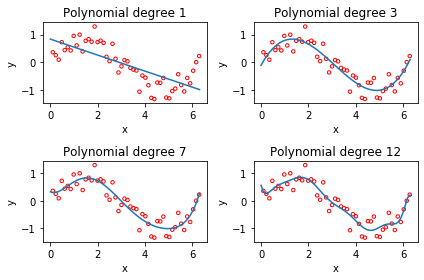

In [11]:
polynomial_regression()

The fit gets better as we increase the degree but we have to be smart and use a correct grade. As we can see while with a poly degree of 3 the fit is already good (rmse decreased a lot), with 7 the improvement is little, while with 12 the fit get worse (even if the rmse continue to decrease)

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [85]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    
    train_size = round(x.shape[0] * ratio)
    indexes = np.arange(x.shape[0])
    np.random.shuffle(indexes)
    
    train_indexes = indexes[:train_size]
    test_indexes = np.setdiff1d(indexes, train_indexes)
    
    x_train = x[train_indexes]
    y_train = y[train_indexes]
    
    x_test = x[test_indexes]
    y_test = y[test_indexes]
    
    return x_train, x_test, y_train, y_test

Then, test your `split_data` function below.

In [59]:
def train_test_split_demo(x, y, degree, ratio, seed, ax):
    """polynomial regression with different split ratios and different degrees."""
    xtr, xte, ytr, yte = split_data(x, y, ratio, seed)
    xpolytr = build_poly(xtr, degree)
    xpolyte = build_poly(xte, degree)
    weights, loss = least_squares(ytr, xpolytr)
    rmse_tr = compute_rmse(ytr,xpolytr,weights)
    rmse_te = compute_rmse(yte,xpolyte,weights)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))
    plot_fitted_curve(
            y, x, weights, degree, ax)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.548
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.254
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=4.651


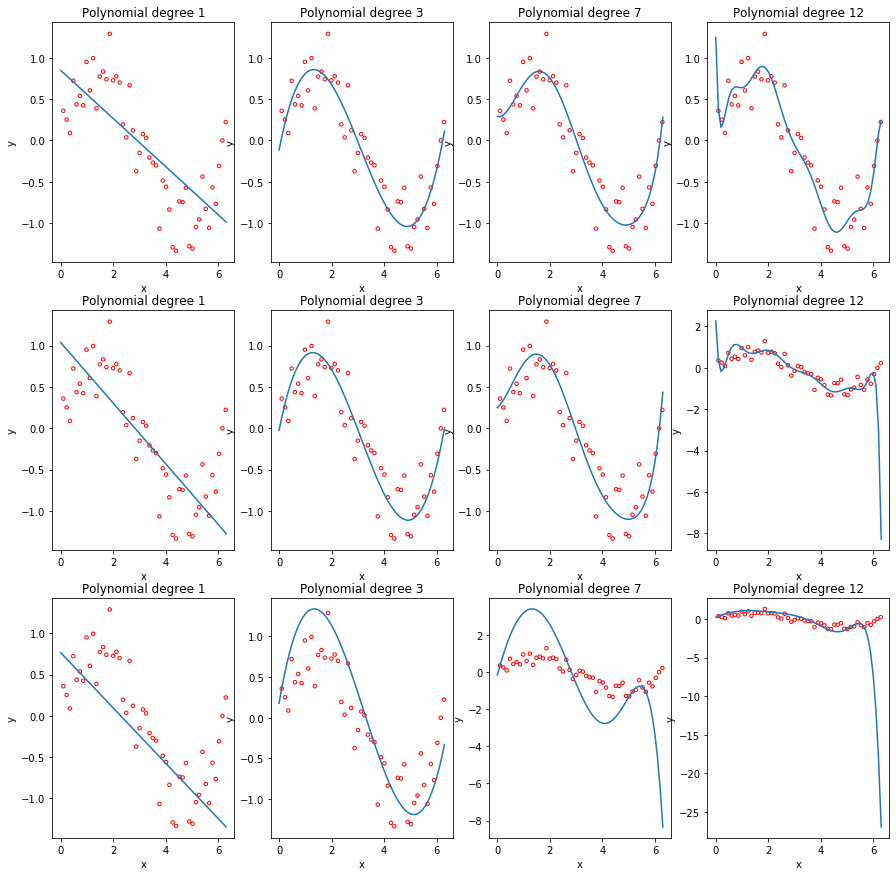

In [88]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

# define the structure of the figure
num_row = 3
num_col = 4
f, axs = plt.subplots(num_row, num_col,figsize=(15,15))
ind=0
for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed, axs[ind // num_col][ind % num_col])
        ind+=1

- Degree 3: it makes sense. The 2 RMSE are almost the same for 90% (because the big part of data is used for training) and aren't the same but quite similar for the other 2 cases. This is because the degree-3 polynomial is a very good fit so also during the verification phase we achieve good results
- Degree 1: it's strange that's is similar to the degree 3 case for the 50% case, and below for the 10%, but it's understandable because we are training with only a small subset. In the first case is above
- Degree 7: Proportions similar to degree 3 for the first 2 cases, big RMSE for the last 1 (altough it as a training of zero). This is because in the last case the degree 7 will perfectly fit the 10% of the samples, and will be far from the others
- Degree 12: As with degree 7, perfect fit of training data that reflect a poor fit on testing

The better splits are the 90% or the 50%, depending on the case. It's better to use them with a degree 3 or 7 polynomial

The test RMSE is so high because it tends to fit all the values in the first slice, then it will do whatever it wants without fitting nothing

Bonus: I think a good split will be a 50% 

# 3 Ridge Regression
Please fill in the function below.

In [40]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N = len(y)
    G = tx.T.dot(tx)
    i = np.linalg.inv(G + 2*N*lambda_*np.eye(G.shape[0]))
    w_star = i.dot(tx.T).dot(y)
    return w_star

In [41]:
#test
xpoly = build_poly(x,3)
w = ridge_regression(y,xpoly,0)
compute_rmse(y,xpoly,w)

0.258582776677375

In [86]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    xtr, xte, ytr, yte = split_data(x, y, ratio, seed)
    xpolytr = build_poly(xtr, degree)
    xpolyte = build_poly(xte, degree)
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        w = ridge_regression(ytr,xpolytr,lambda_)
        rmsetr = compute_rmse(ytr,xpolytr,w)
        rmsete = compute_rmse(yte,xpolyte,w)
        rmse_tr.append(rmsetr)
        rmse_te.append(rmsete)
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

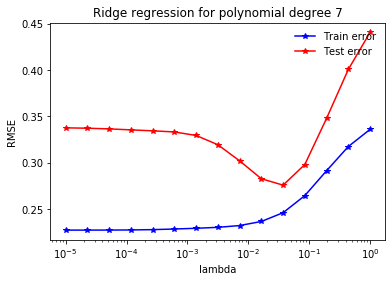

In [87]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)